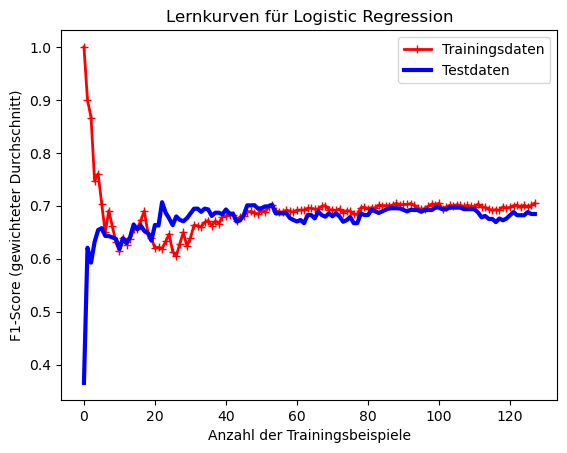

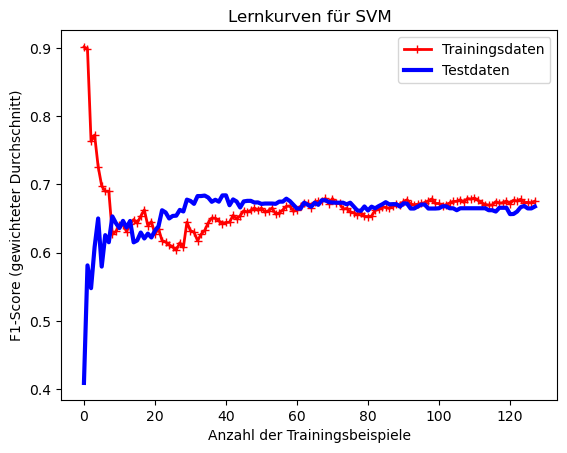

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Daten laden und vorbereiten
file_path = "data/Obesity_Dataset_FE_WOBMI.xlsx"
data = pd.read_excel(file_path)
X = data.drop(columns=['Class'])
y = data['Class'] - data['Class'].min()  # Zielvariablen auf 0-basierte Indizes setzen

# Training/Test-Aufteilung
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Feature-Auswahl
selector = SelectFromModel(LinearSVC(penalty="l2", dual=False, random_state=42)).fit(X_train, y_train)
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

# Modelle und Hyperparameter
models = {
    'Logistic Regression': {
        'model': Pipeline([('classification', LogisticRegression(max_iter=500, random_state=42))]),
        'params': {'classification__C': [0.01, 0.1, 1, 10]}
    },
    'SVM': {
        'model': Pipeline([('classification', LinearSVC(dual=False, max_iter=1000, random_state=42))]),
        'params': {'classification__C': [0.01, 0.1, 1, 10]}
    }
}

# Lernkurven plotten
def plot_learning_curves(model, X_train, y_train, X_test, y_test, model_name):
    train_scores, test_scores = [], []
    for m in range(10, X_train.shape[0], 10):
        model.fit(X_train[:m], y_train[:m])
        train_scores.append(f1_score(y_train[:m], model.predict(X_train[:m]), average='weighted'))
        test_scores.append(f1_score(y_test, model.predict(X_test), average='weighted'))

    plt.plot(train_scores, "r-+", linewidth=2, label="Trainingsdaten")
    plt.plot(test_scores, "b-", linewidth=3, label="Testdaten")
    plt.title(f"Lernkurven für {model_name}")
    plt.xlabel("Anzahl der Trainingsbeispiele")
    plt.ylabel("F1-Score (gewichteter Durchschnitt)")
    plt.legend()
    plt.show()

# Modelle trainieren und Lernkurven plotten
for name, config in models.items():
    grid_search = GridSearchCV(config['model'], config['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    plot_learning_curves(grid_search.best_estimator_, X_train, y_train, X_test, y_test, name)
